# Datavidia 7.0
## By: Tim VWXYZ - Universitas Trunojoyo
### 1. Mohamad Zaelani (Leader) - mohamadzaelani09@gmail.com
### 2. Yusuf Sugiono - ysf.sugiono@gmail.com
### 3. Viki Wahyudi - vikiwahyudi1982@gmail.com

# 1. Understand the Problem (Business and Data)

## A. Understand the Business

Pada tahap ini kami berusaha memahami permasalahan yang sedang dihadapi. Pada kompetisi ini kami diminta untuk membuat model yang dapat memprediksi apakah sebuah review terhadap hotel adalah review buruk atau review positif.

Problem Statement : Prediksi apakah suatu review termasuk review positif atau negatif.

Dengan membuat model yang dapat memprediksi sebuah review apakah termasuk review positif atau negatif maka perusahaan dapat menangani permasalahan dengan segera.

## B. Understand the Data

Pada tahap ini kami akan berusaha memahami dataset yang diberikan. Tahapan ini sangat penting karena pada kasus dilapangan terkadang memiliki kualitas yang buruk sehingga perlu penanganan lebih lanjut.

Berikut data-data yang akan digunakan:
- train.csv - Data training yang berisi review beserta kategori sentimen review tersebut
- test.csv - Data uji / test yang berisi review yang ingin diketahui kategori sentimennya
- sample_submission.csv - File yang berisi contoh format submisi pada platform kaggle

### Import Library

In [1]:
import string 
import re
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist
nltk.download('punkt')
from wordcloud import WordCloud, ImageColorGenerator

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Import Files

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

### Info Pada Dataset

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14856 entries, 0 to 14855
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    14856 non-null  object
 1   review_text  14856 non-null  object
 2   category     14856 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 348.3+ KB


In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3714 entries, 0 to 3713
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    3714 non-null   object
 1   review_text  3714 non-null   object
dtypes: object(2)
memory usage: 58.2+ KB


### Cek 5 Data Teratas

In [5]:
train_df.head()

,review_id,review_text,category
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0


In [6]:
test_df.head()

,review_id,review_text
0,7302180ac7160f04a405d8aa7bd6beb8,"Kasur rusak, punggung saya sakit, kasurnya ga ..."
1,3184c670e170f565c7522eb76a320ba1,gerah
2,e33abf6bb5d5a9a77c339043b1725dc8,"tempat ridur atas bawah.. ac nya pararel, tdk ..."
3,061d388950340070a6ac03fabc9027b0,"ac kurang dingin, tidak ada snack sperti di foto"
4,e62d87c348674b6c06856964f3ab16b8,Lumayan untuk guest house dengan standart harg...


Pada tahap bussines understanding dan data undersanding, terdapat beberapa hal yang dapat kami simpulkan:

- Target Variable: `category`
- Problem Type:  Klasifikasi Binary dengan class '1' (review positif) dan '0' (review negatif)
- Metric:  Macro F1-Score
- Tidak ada kolom yang memiliki missing value untuk setiap dataset
- Kolom `review_id` tidak akan digunakan dalam proses training model sehingga akan di hapus
- Kolom `review_text` berisi kalimat-kalimat review dari pelanggan hotel sehingga kami harus melakukan Pemrosesan Bahasa Alami (Natural Language Processing).

# 2. Data Preprocessing

Pada kasus pemrosesan bahasa alami, data yang akan di proses merupakan data yang tidak terstruktur dimana data-data tersebut berupa teks atau kalimat. Oleh karena itu diperlukan pengolahan terhadap data tersebut sehingga menjadi data yang terstruktur agar dapat digunakan pada tahap berikutnya.

Pada tahap ini, kami manggunakan *library* `nltk` atau *Natural Language Tolkit*. Library `nltk` lazim digunakan untuk pemodelan dan preprosesing teks. `nltk` menyediakan metode-metode yang baik untuk mempersiapkan teks sebelum digunakan pada tahap selanjutnya.

Tahapan preprosesing data yang akan kami lakukan sebagai berikut:
1. Case Folding
2. Tokenizing
3. Normalisasi
4. Filtering

Sebelum melakukan teknik preprosesing terhadap data yang diberikan, kami akan menghapus kolom `review_id` karena kolom tersebut tidak akan digunakan dalam proses training.

In [7]:
train_df = train_df.drop(['review_id'], axis=1)
test_df = test_df.drop(['review_id'], axis=1)

## Case Folding

*Case folding* merupakan teknik preprosesing yang paling sederhana. Tujuan dari case folding adalah untuk mengubah semua huruf dalam dataset menjadi huruf kecil. Selain itu, karakter-karakter selain huruf juga akan dihapus. Pada tahapan ini kami akan menggunakan modul yang sudah tersedia.


### Mengubah Text Menjadi Lowercase

Huruf besar dan kecil akan dianggap berbeda sehingga perlu ditangani lebih lanjut. Proses *case folding* pada data yang kami miliki akan menggunakan fungsi `lower()` pada class `Pandas.Series.str`. 

In [8]:
train_df['review_text'] = train_df['review_text'].str.lower()
test_df['review_text'] = test_df['review_text'].str.lower()

### Menghapus New Line

Untuk menghapus karekter *new line* kami menggunakan fungsi `replace()` dan regular expression/regex.

In [9]:
train_df['review_text'] = train_df['review_text'].replace('\n',' ', regex=True)
test_df['review_text'] = test_df['review_text'].replace('\n',' ', regex=True)

### Menghapus Karakter Angka

Untuk menghapus angka dalam data, kami menggunakan *Regular Expression (Regex)*. Kami juga akan menggunakan fungsi `replace()` untuk proses ini.

In [10]:
train_df['review_text'] = train_df['review_text'].str.replace('\d+', ' ')
test_df['review_text'] = test_df['review_text'].str.replace('\d+', ' ')

### Menghapus Tanda Baca dan Whitespace

Kami juga akan menghapus tanda baca dan whitespace yang berlebihan. Untuk melakukan itu, kami menggunakan modul `nltk` untuk menghapus tanda baca *(punctuation)* dan menggunakan modul `re` atau *regular expression*.

In [11]:
#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

test_df['review_text'] = test_df['review_text'].apply(remove_punctuation)
train_df['review_text'] = train_df['review_text'].apply(remove_punctuation)

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

test_df['review_text'] = test_df['review_text'].apply(remove_whitespace_LT)
train_df['review_text'] = train_df['review_text'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

test_df['review_text'] = test_df['review_text'].apply(remove_whitespace_multiple)
train_df['review_text'] = train_df['review_text'].apply(remove_whitespace_multiple)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", " ", text)

test_df['review_text'] = test_df['review_text'].apply(remove_singl_char)
train_df['review_text'] = train_df['review_text'].apply(remove_singl_char)

## Tokenizing

*Tokenizing* merupakan proses untuk memisahkan teks menjadi potongan-potongan yang disebut sebagai token untuk kemudian dilakukan analisa. Dalam NLP, token merupakan "kata" yang diekstrak pada sebuah kalimat. Untuk melakukan *tokenizing* kami menggunakan fungsi `word_tokenize()` yang tersedia pada class `nltk.tokenize` pada modul `nltk`.

In [12]:
# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)

test_df['review_text_token'] = test_df['review_text'].apply(word_tokenize_wrapper)
train_df['review_text_token'] = train_df['review_text'].apply(word_tokenize_wrapper)

## Normalisasi

Tahap normalisasi bertujuan untuk menyeragamkan kata yang memiliki makna sama namun dengan penulisan yang berbeda. Hal ini bisa diakibatkan karena kesalahan penulisan, penyingkatan kata, ataupun penggunaan "bahasa gaul".

Untuk itu kami harus menyiapkan dataset untuk mapping kata yang ingin diseragamkan. Kami sudah menyiapkan dataset tersebut yang tersedia pada link github dibawah. Selanjutnya kami telah membuat fungsi yang dapat digunakan untuk proses normalisai.

In [ ]:
# Download dataset untuk normalisasi
!wget https://raw.githubusercontent.com/zaelani23/datavidia7/main/normalisasi.txt

In [14]:
def normalisasi(token):
  kbba=[kamus.strip('\n').strip('\r') for kamus in open('normalisasi.txt')]
  dic={}
  for i in kbba:
    (key,val)=i.split('\t')
    dic[str(key)]=val
  final_string = ' '.join(str(dic.get(word, word)) for word in token).split()
  return final_string
train_df['normalisasi'] = train_df['review_text_token'].apply(normalisasi)
test_df['normalisasi'] = test_df['review_text_token'].apply(normalisasi)

## Filtering (Menghapus Stopwords)

Stopwords merupakan kata-kata yang sering muncul dan dianggap tidak memiliki makna. Dalam bahasa Indonesia, beberapa contoh stopwords yang sering muncul seperti "yang", "dan", "di", "dari", dan lain lain. Menghapus stopwords bertujuan untuk menghapus kata yang memiliki makna rendah, sehingga kita dapat lebih fokus terhadap kata yang memiliki makna lebih tinggi dalam sebuah kalimat.

Untuk melakukan filtering stopwords, kami sudah membuat beberapa list kata yang termasuk stopwords. Selanjutnya kami membuat sebuah fungsi `stopwords_removal` yang akan mengecek apakah sebuah token ada di dalam list stopwords, jika 'Ya' maka kate tersebut akan dihapus dari token.

In [15]:
list_stopwords = (['yg', 'dg', 'dgn', 'dengan', 'ny', 'd', 'klo',
                   'kalo', 'amp', 'biar', 'bikin', 'bilang', 'jadi',
                   'krn', 'nya', 'nih', 'sih', 'untuk', 'juga', 'the',
                   'si', 'tau', 'tuh', 'utk', 'ya', 'dari', 'and',
                   'jd', 'jgn', 'sdh', 'aja', 'n', 't', 'karena',
                   'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                   '&amp', 'yah', 'yng', 'yang', 'di', 'ada', 'dan',
                   'saya', 'ke', 'dll', 'gw', 'gwe', 'gua', 'itu', 'saja'])

list_stopwords = set(list_stopwords)


#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

train_df['normalisasi'] = train_df['normalisasi'].apply(stopwords_removal)
test_df['normalisasi'] = test_df['normalisasi'].apply(stopwords_removal)

## 3. Exploratory Data Analysis (EDA)

*Exploratory Data Analysis (EDA)* adalah proses memeriksa dataset untuk menemukan fakta tentang data dan mengkomunikasikan fakta tersebut, seringkali melalui visualisasi.

## Distribusi Kategori Review

In [16]:
cat = train_df['category'].value_counts()

In [17]:
print('Jumlah review negatif', cat[0])
print('Jumlah review positif', cat[1])

Jumlah review negatif 12839
Jumlah review positif 2017


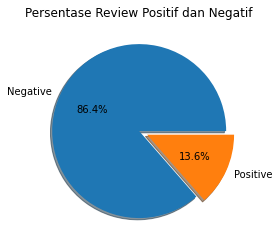

In [18]:
flavors = ('Negative', 'Positive')
explode = (0, 0.1)

plt.title('Persentase Review Positif dan Negatif')
plt.pie(
    cat,
    labels=flavors,
    autopct='%1.1f%%',
    explode=explode,
    shadow=True
    )
plt.show()

Dari hasil diatas kita dapat ketahui bahwa dalam dataset yang kita miliki terdapat 86.4% review negatif dan 13.6% review positif. Total dari keseluruhan sampel yang kita miliki sebanyak 14856. Kemudian dari hasil tersebut dapat kita simpulkan bahwa data yang kita miliki adalah data yang *imbalance*.

## Text length

### Distribusi Jumlah Kata Seluruh Review

count    14856.000000
mean        13.894184
std         11.725130
min          0.000000
25%          5.000000
50%         10.000000
75%         18.000000
max        103.000000
Name: normalisasi, dtype: float64


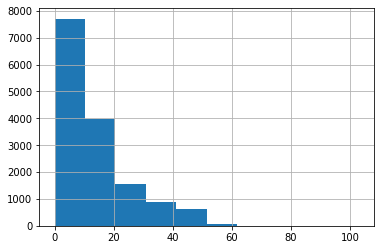

In [19]:
lens = train_df['normalisasi'].apply(lambda x: len(x))
print(lens.describe())
lens.hist()

Hasil diatas menunjukkan bahwa panjang kata rata-rata yang terdapat pada dataset adalah 14 kata. Kemudian terdapat review dengan panjang 0 kata, maka kami akan menghapus data tersebut.

In [20]:
train_df.drop(train_df[lens < 1].index, inplace=True)

### Distribusi Jumlah Kata Review Positif

count    2017.000000
mean       11.542885
std         9.553020
min         1.000000
25%         6.000000
50%         9.000000
75%        13.000000
max       103.000000
Name: normalisasi, dtype: float64


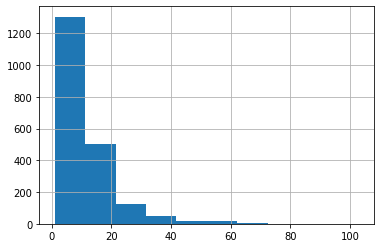

In [21]:
lens_positive = train_df.loc[(train_df.category == 1), 'normalisasi'].apply(lambda x: len(x))
print(lens_positive.describe())
lens_positive.hist()

### Distribusi Jumlah Kata Review Negatif

count    12818.000000
mean        14.286940
std         11.985149
min          1.000000
25%          5.000000
50%         10.000000
75%         19.000000
max         61.000000
Name: normalisasi, dtype: float64


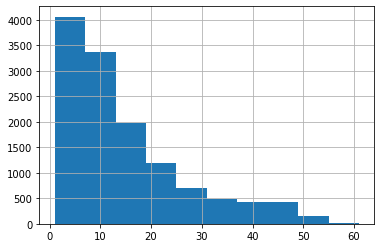

In [22]:
negative = train_df.loc[(train_df.category == 0), 'normalisasi'].apply(lambda x: len(x))
print(negative.describe())
negative.hist()

## Term Frequency Analysis

In [23]:
words = train_df['normalisasi']
allwords = []
for wordlist in words:
  allwords += wordlist

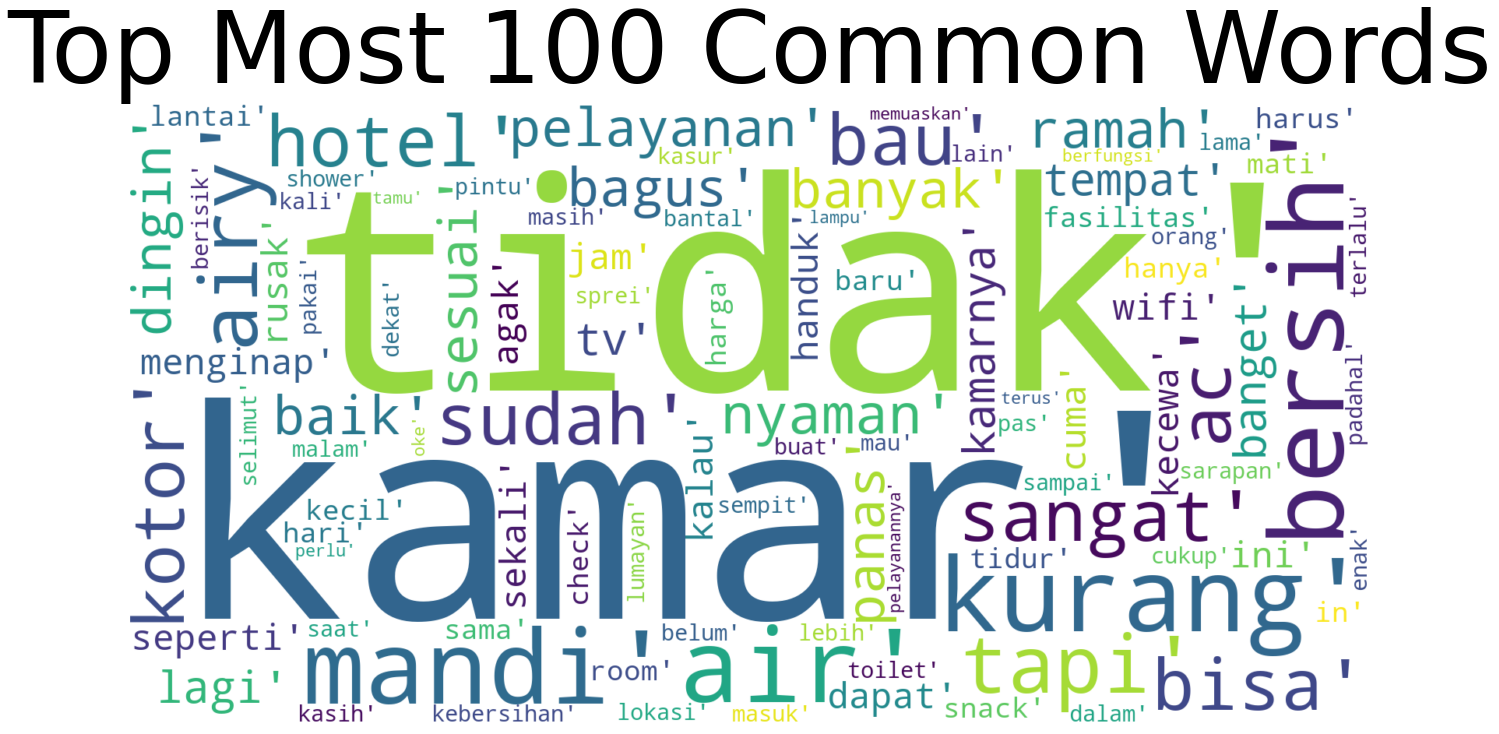

In [25]:
mostcommon = FreqDist(allwords).most_common(100)

wordcloud = WordCloud(width=1600, 
                      height=800,
                      background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10),
                 facecolor='white')
plt.imshow(wordcloud,
           interpolation='bilinear')
plt.axis('off')
plt.title('Top Most 100 Common Words', fontsize=100)

plt.tight_layout(pad=0)
plt.show()

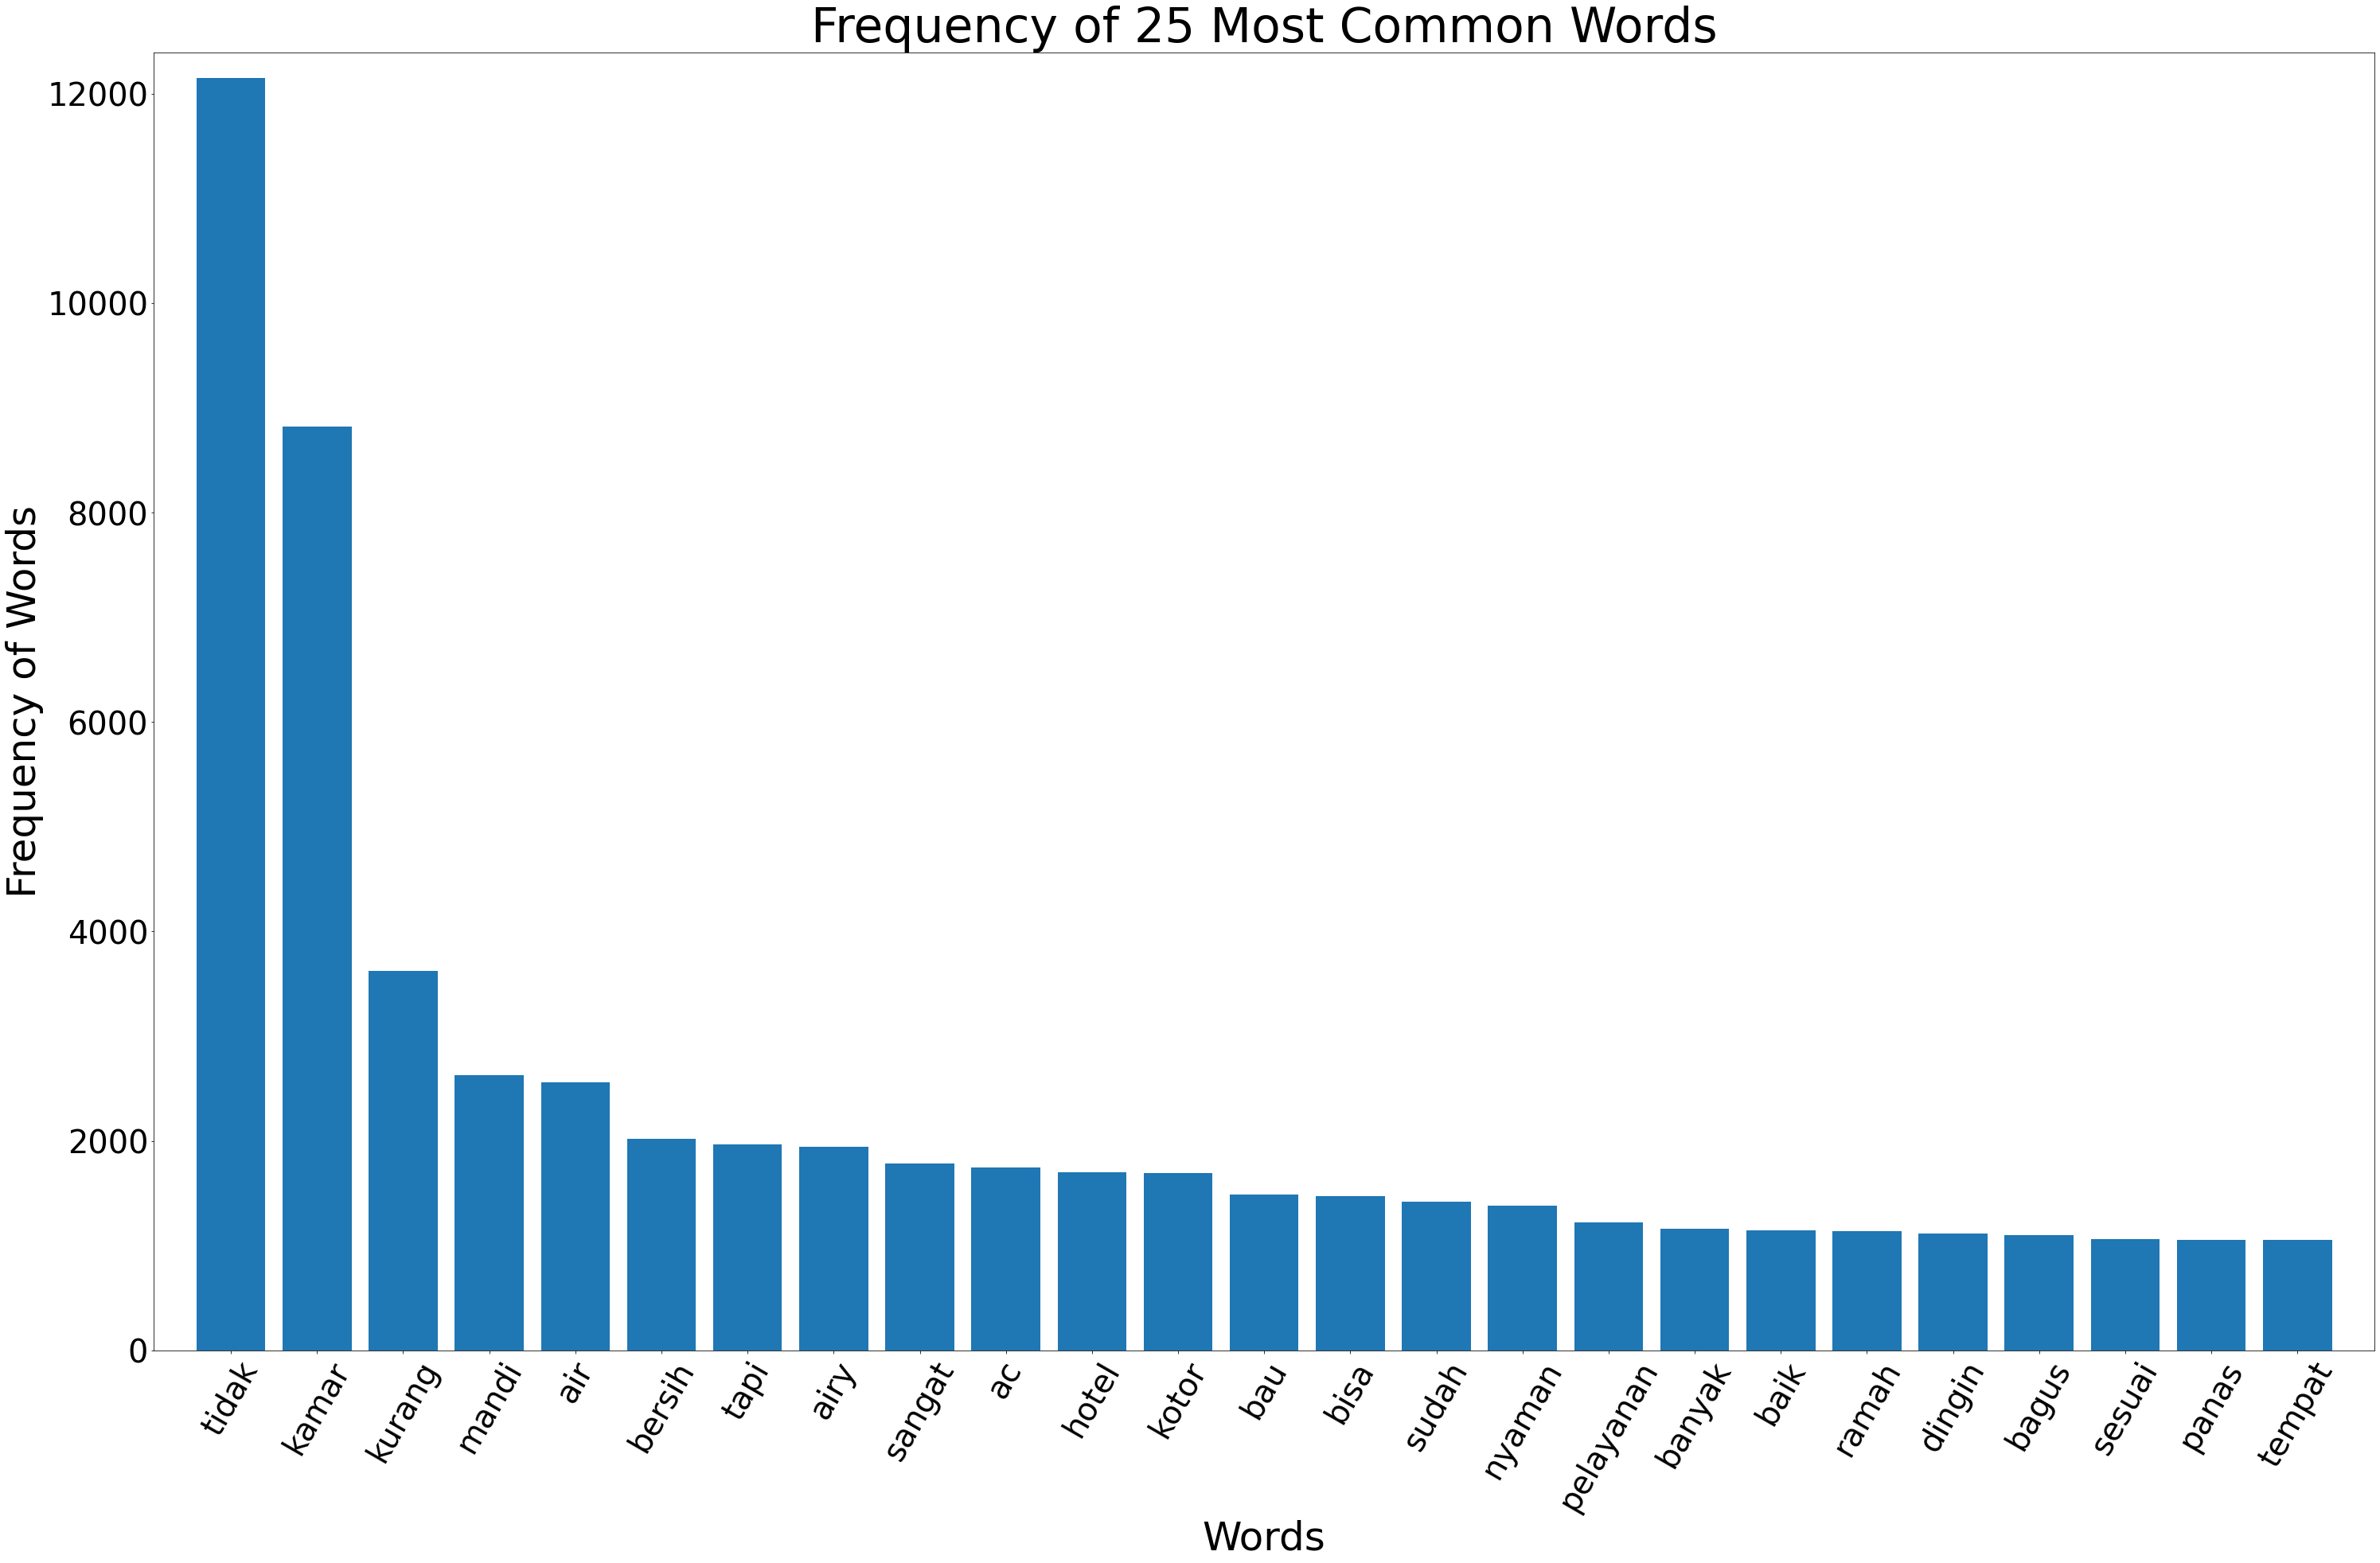

In [26]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)

plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60,
           fontsize=40)
plt.title('Frequency of 25 Most Common Words',
          fontsize=60)
plt.show()

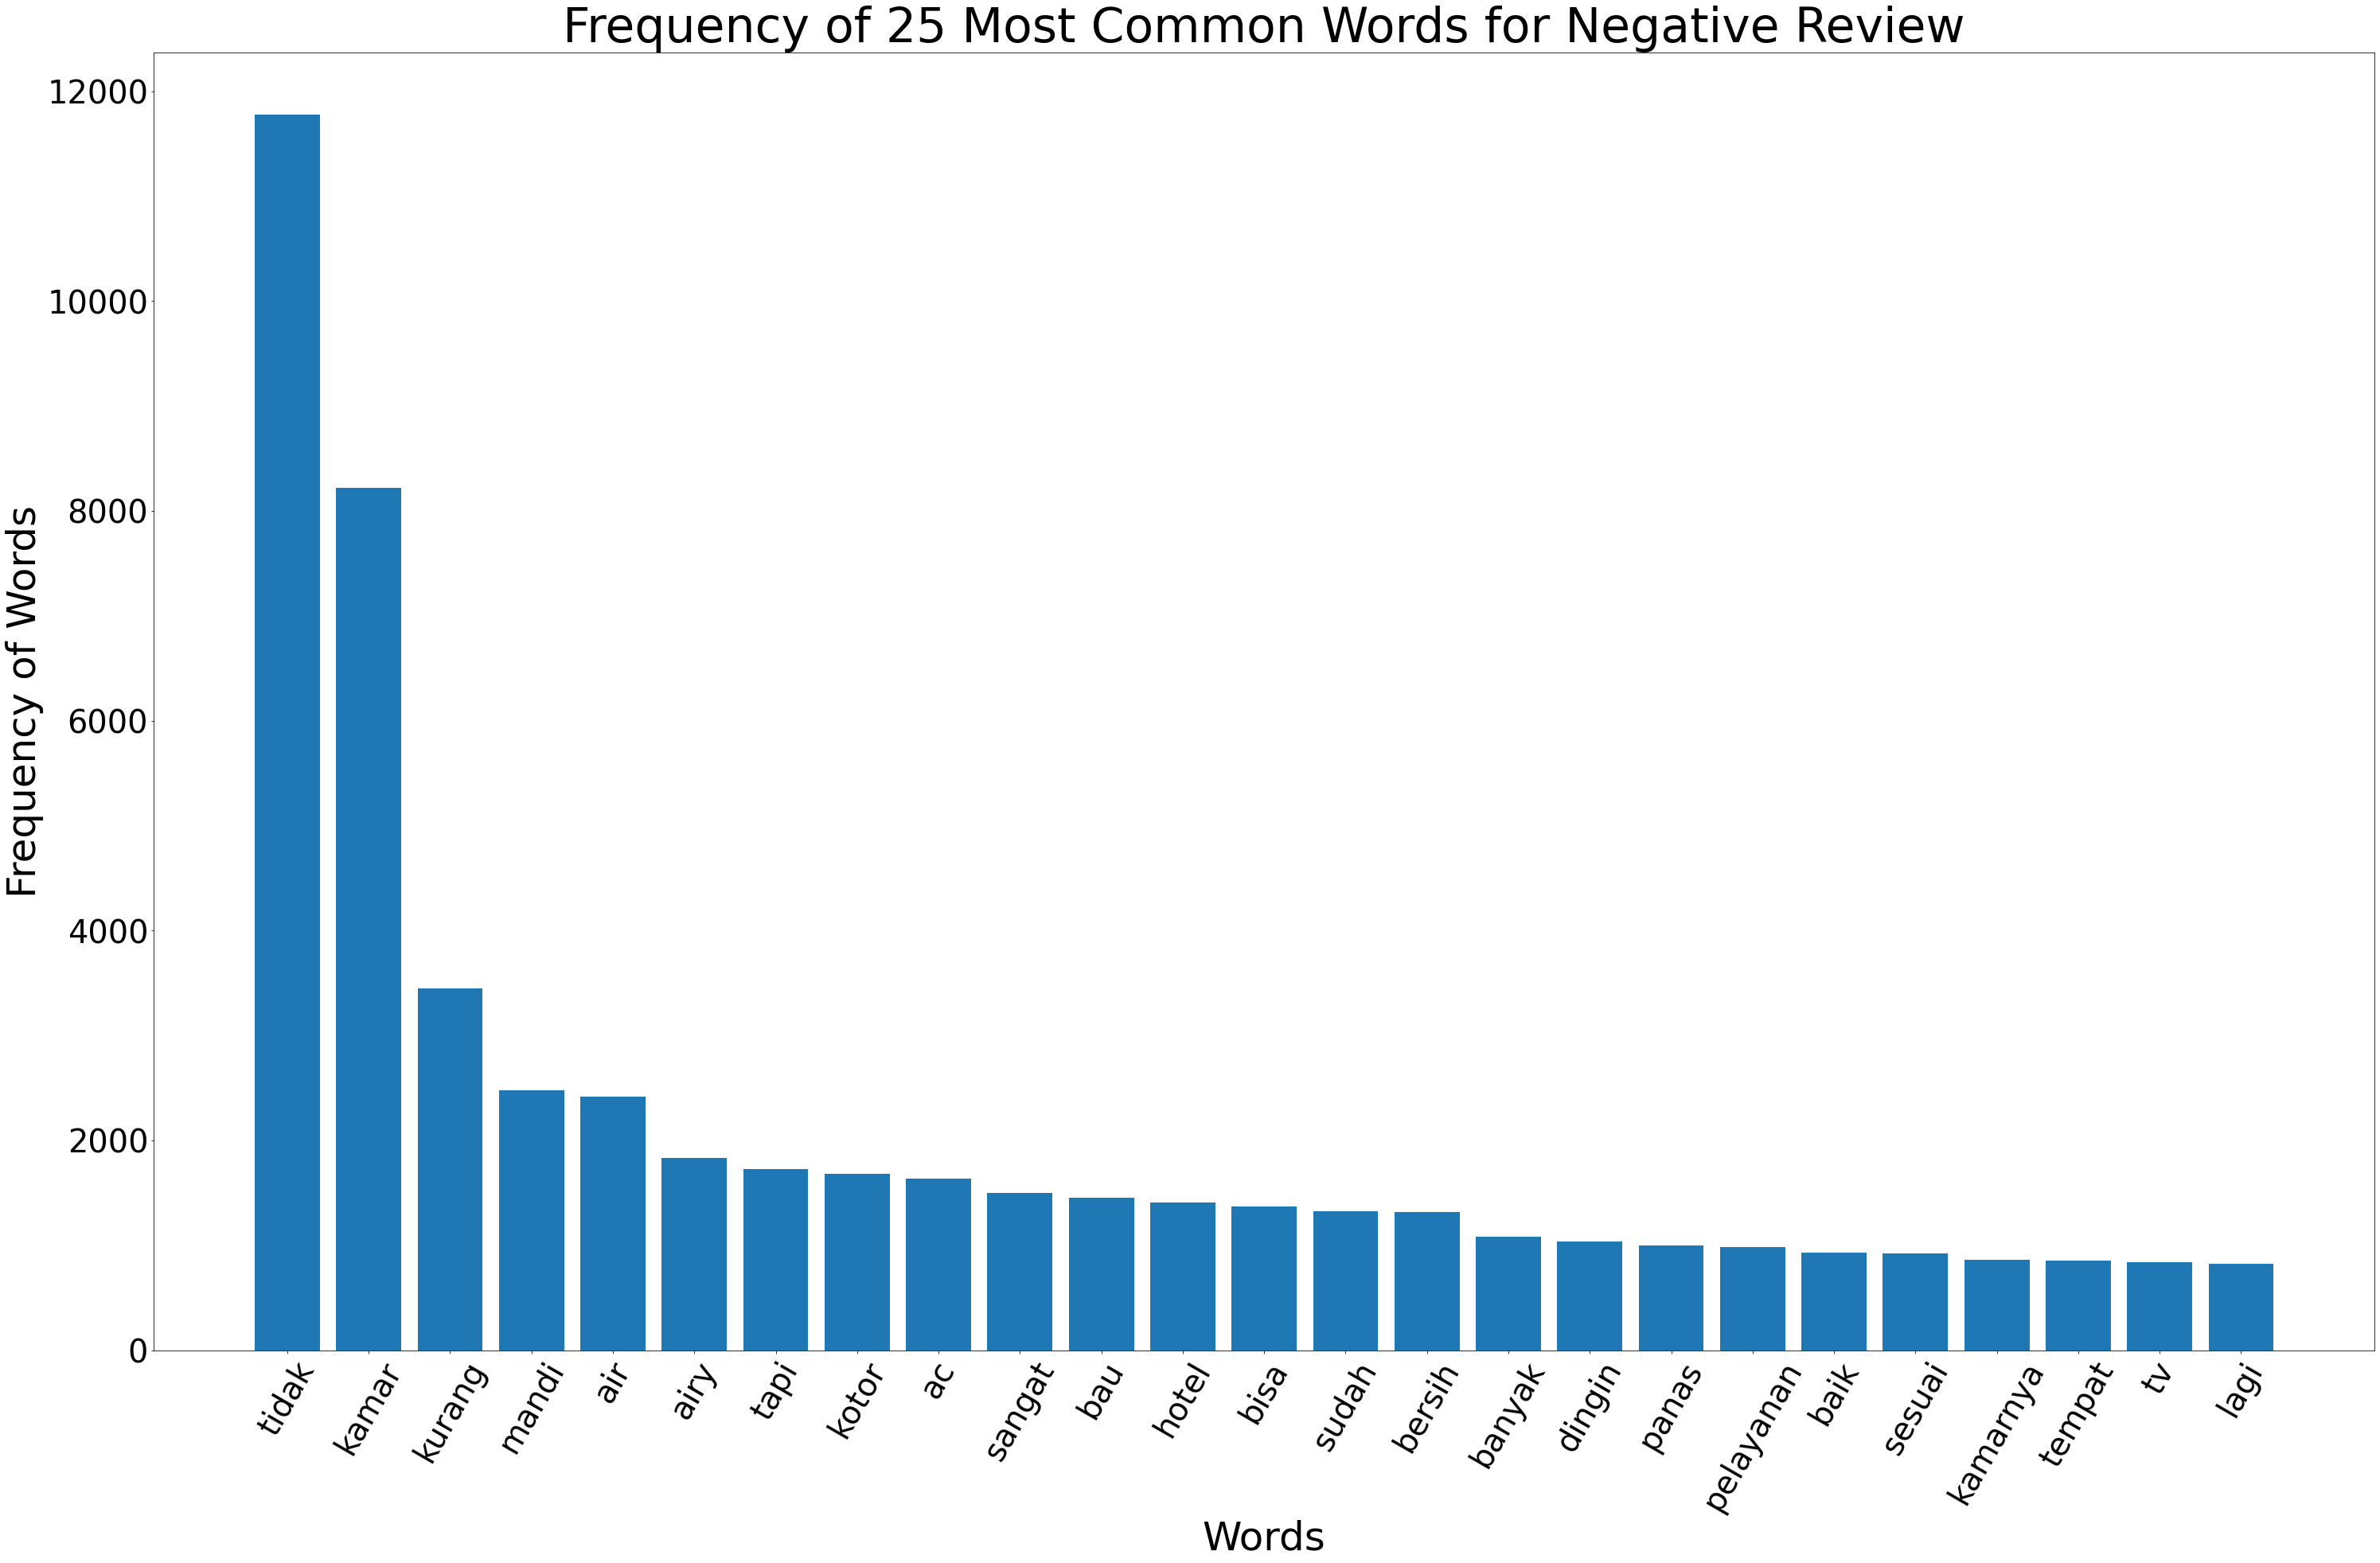

In [27]:
def gabung(sentence):
  return ' '.join(sentence)
train_df['normalisasi_text'] = train_df['normalisasi'].apply(gabung)

group_by = train_df.groupby('category')['normalisasi_text'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[0]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(50,30))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Negative Review', fontsize=60)
plt.show()

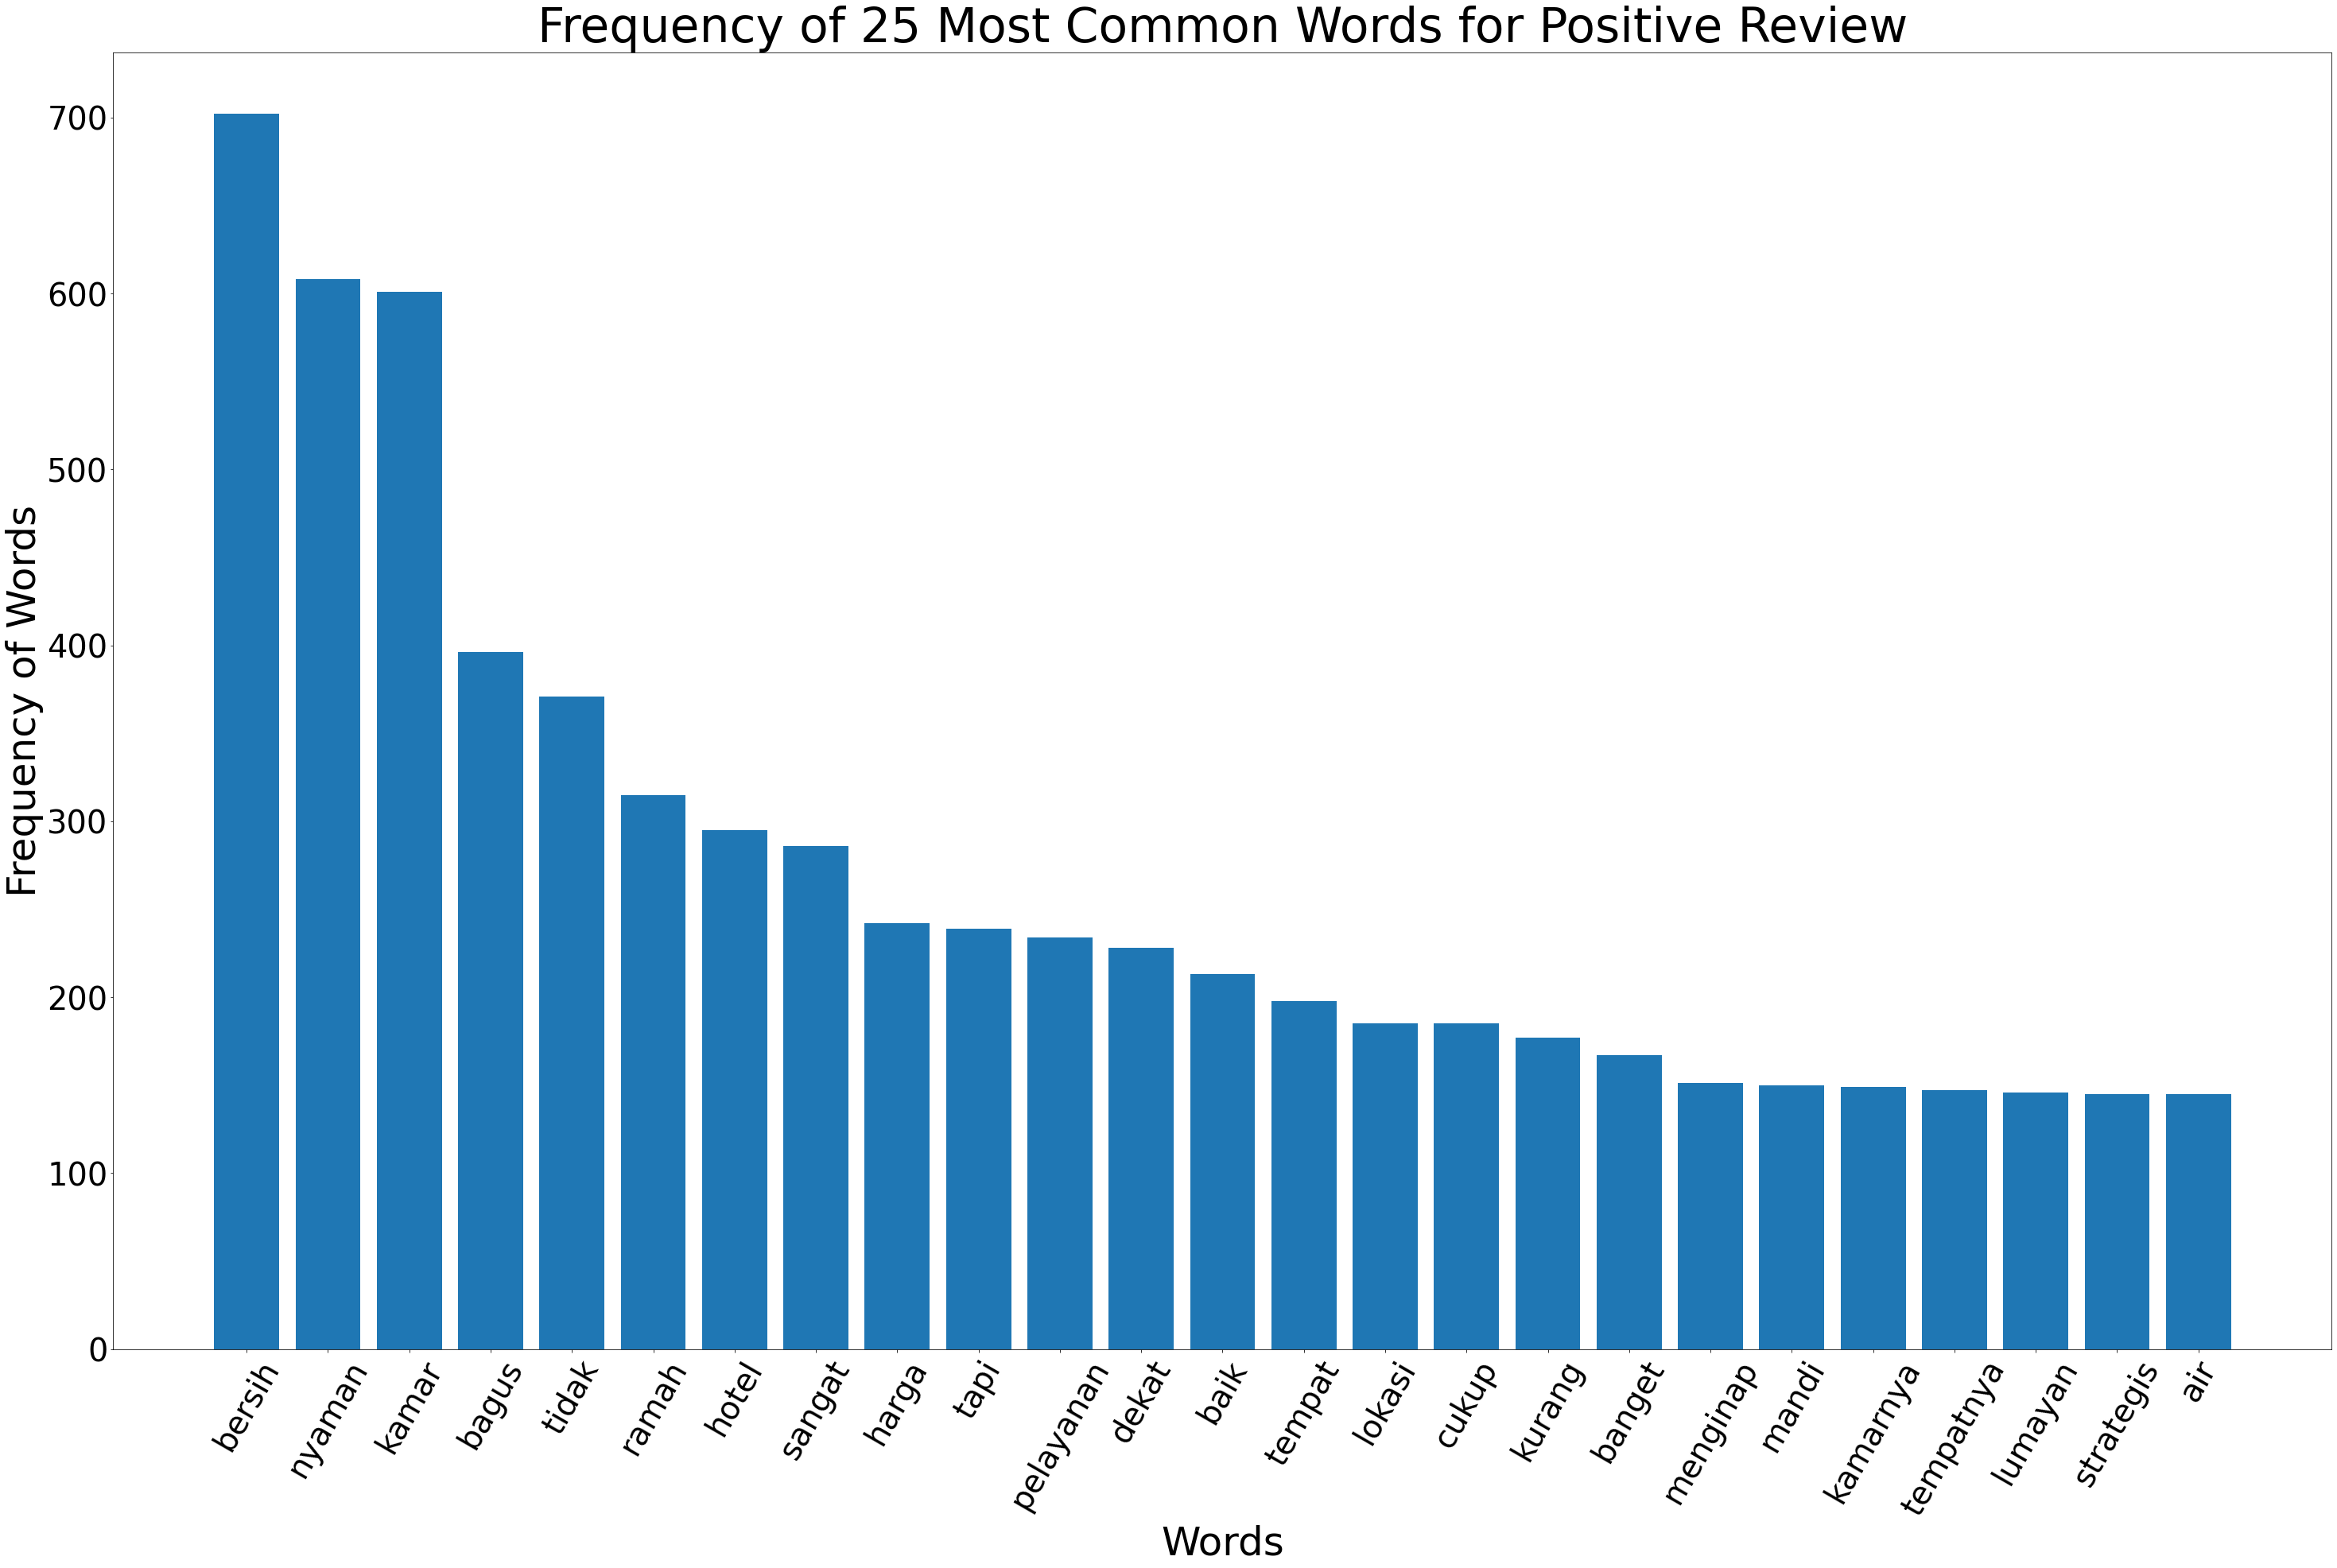

In [28]:
group_by = train_df.groupby('category')['normalisasi_text'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_1 = group_by.iloc[1]
words1 = list(zip(*group_by_1))[0]
freq1 = list(zip(*group_by_1))[1]
plt.figure(figsize=(50,30))
plt.bar(words1, freq1)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Positive Review', fontsize=60)
plt.show()

# 4. Feature Enginering

Machine learning hanya bisa memproses data dalam bentuk angka, oleh karena itu diperlukan proses rekayasa fitur *(Feature Enginering)* untuk mengubah data dalam bentuk teks menjadi data dalam bentuk angka. Pada tahap ini kami menggunakan *class* `tf.keras.preprocessing.text.Tokenizer`. 

*Class* ini memungkinkan untuk membuat vektor korpus teks, dengan mengubah setiap teks menjadi urutan bilangan bulat `sequence` (setiap bilangan bulat menjadi indeks token dalam `dictionary`) atau menjadi vektor di mana koefisien untuk setiap token dapat berupa biner, berdasarkan jumlah kata dan/atau berdasarkan tf-idf. Argumen yang digunakan dalam *class* ini adalah sebagai berikut:
- **num_words** : jumlah kata maksimum yang harus disimpan, berdasarkan frekuensi kata. Hanya kata-kata `num_words-1` paling umum yang akan disimpan.
- **filter** : string di mana setiap elemen adalah karakter yang akan difilter dari teks. Default dari argumen ini adalah semua tanda baca, ditambah tab dan jeda baris, tanpa karakter `'`.
- **lower** : boolean. Apakah akan mengonversi teks menjadi huruf kecil. Default `True`
- **split**: str. Pemisah untuk memisahkan kata.
- **char_level** : jika `True`, setiap karakter akan diperlakukan sebagai token.
- **oov_token** : jika diberikan, maka akan ditambahkan ke `word_index` dan digunakan untuk mengganti kata-kata yang tidak ada selama pemanggilan fungsi `text_to_sequence`

Selanjutnya kami akan menambahkan *padding* yang bertujuan untuk menyeragamkan panjang dari `sequence`.


In [29]:
# Memisahkan Review dengan Labelnya
review = train_df['normalisasi']
label = train_df['category']

In [30]:
# Memecah dataset menjadi training set dan validation set
review_latih, review_test, label_latih, label_test = train_test_split(review, label, test_size=0.2, random_state=42)

In [31]:
pad_type = 'pre'
trunc_type = 'pre'

# Tokenize our training data
tokenizer = Tokenizer(num_words=1000, oov_token='x')
tokenizer.fit_on_texts(review_latih)
tokenizer.fit_on_texts(review_test)

# Encode training data sentences into sequences
sekuens_latih = tokenizer.texts_to_sequences(review_latih)
sekuens_test = tokenizer.texts_to_sequences(review_test)

# Get max training sequence length
maxlen = max([len(x) for x in sekuens_latih])

# Pad the training sequences
padded_latih = pad_sequences(sekuens_latih, padding=pad_type, truncating=trunc_type, maxlen=maxlen) 
padded_test = pad_sequences(sekuens_test, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# 5. Modeling

Tahap modeling bertujuan untuk melatih model menggunakan dataset yang tersedia yang kemudian setelah melalui proses training, model tersebut dapat digunakan untuk memprediksi label dari data baru yang belum pernah dijumpai. Pada tahap ini kami menggunakan arsitektur model *Recurrent Neural Networks (RNNs)*. Dalam arsitektur *RNNs* yang kami buat, kami menggunakan 4 layer utama dan menggunakan layer 'dropout' pada masing-masing layer yang bertujuan untuk mengurangi 'overfiting' pada data training. 4 Layer yang kami gunakan adalah sebagai berikut:
1. Embedding <br>
Layer Embedding diinisialisasi dengan bobot acak dan akan mempelajari embedding untuk semua kata dalam set data pelatihan. 
2. LSTM (Long Short-Term Memory) <br>
LSTM adalah jenis arsitektur RNN yang sangat bagus dalam menangani urutan informasi yang panjang. Layer ini mengambil input dimensi (batch size, maxlen, dimensi embedding) dan mengembalikan output dimensi (batch size, 32). Ukuran output yang lebih besar berarti model yang lebih kompleks; kami telah memilih 32 setelah melakukan *tuning* berdasarkan kinerja model.
3. Dense <br>
Sebuah hidden layer dengan fungsi aktifasi 'relu"
4. Dense <br>
Layer terakhir untuk mengembalikan prediksi review positif atau negatif.

In [57]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=1000, output_dim=16),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', tfa.metrics.F1Score(num_classes=1, average='macro', threshold=0.5)])

Berikut *summary* dari model yang kami buat

In [58]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          16000     
_________________________________________________________________
dropout_20 (Dropout)         (None, None, 16)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

Setelah menyusun arsitektur model RNN, kami melakukan fitting dataset pada model dengan *epochs* 30.

In [59]:
num_epochs = 30
hist = model.fit(padded_latih, label_latih,
                 epochs=num_epochs,
                 validation_data=(padded_test, label_test),
                 verbose=2)

Epoch 1/30
371/371 - 5s - loss: 0.4532 - accuracy: 0.8536 - f1_score: 0.0302 - val_loss: 0.2834 - val_accuracy: 0.8648 - val_f1_score: 0.0000e+00
Epoch 2/30
371/371 - 3s - loss: 0.3119 - accuracy: 0.8854 - f1_score: 0.3385 - val_loss: 0.2042 - val_accuracy: 0.9400 - val_f1_score: 0.7472
Epoch 3/30
371/371 - 3s - loss: 0.2727 - accuracy: 0.9081 - f1_score: 0.5634 - val_loss: 0.1787 - val_accuracy: 0.9424 - val_f1_score: 0.7717
Epoch 4/30
371/371 - 3s - loss: 0.2566 - accuracy: 0.9125 - f1_score: 0.5958 - val_loss: 0.1836 - val_accuracy: 0.9403 - val_f1_score: 0.7330
Epoch 5/30
371/371 - 3s - loss: 0.2399 - accuracy: 0.9202 - f1_score: 0.6449 - val_loss: 0.1718 - val_accuracy: 0.9447 - val_f1_score: 0.7630
Epoch 6/30
371/371 - 3s - loss: 0.2327 - accuracy: 0.9205 - f1_score: 0.6443 - val_loss: 0.1670 - val_accuracy: 0.9471 - val_f1_score: 0.7792
Epoch 7/30
371/371 - 3s - loss: 0.2265 - accuracy: 0.9226 - f1_score: 0.6559 - val_loss: 0.1625 - val_accuracy: 0.9508 - val_f1_score: 0.7995
Ep

# 6. Validasi

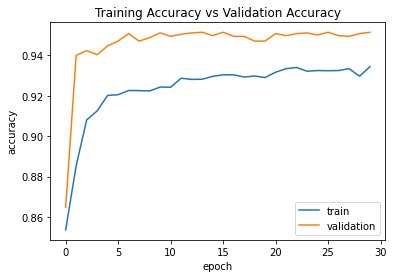

In [63]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

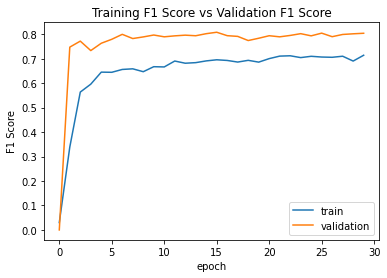

In [66]:
# summarize history for F1 Score
plt.plot(hist.history['f1_score'])
plt.plot(hist.history['val_f1_score'])
plt.title('Training F1 Score vs Validation F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

Dari hasil grafik diatas, skor validasi lebih tinggi daripada skor training disebabkan karena penggunaan layer dropout pada arsitektur model yang kami buat.

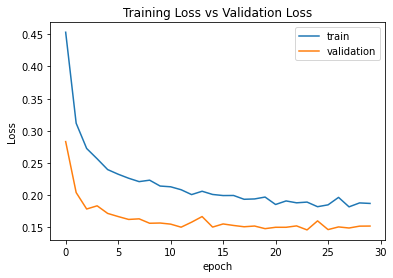

In [65]:
# summarize history for F1 Score
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# 7. Kesimpulan

Hasil dari model yang kami buat memiliki skor Macro F1 0.89835 pada public leaderboard. skor dari model masih dapat ditingkatkan dengan teknik preprocessing data yang tepat

# Referensi

- https://medium.com/@ksnugroho/dasar-text-preprocessing-dengan-python-a4fa52608ffe
- https://yunusmuhammad007.medium.com/text-preprocessing-menggunakan-pandas-nltk-dan-sastrawi-untuk-large-dataset-5fb3c0a88571
- https://dair.ai/Exploratory_Data_Analysis_for_Text_Data/
- https://keras.io/api/preprocessing/text/
- https://github.com/google/applied-machine-learning-intensive

In [53]:
sekuens_submit = tokenizer.texts_to_sequences(test_df['normalisasi'])
padded_submit = pad_sequences(sekuens_submit, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [55]:
s = model.predict_classes(padded_submit)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [56]:
submission['category'] = s
submission.to_csv('submission.csv', index=False)